In [1]:
import tensorflow as tf
sess=tf.Session()    
saver = tf.train.import_meta_graph('./model/final_model.meta')


In [2]:
saver.restore(sess,tf.train.latest_checkpoint('./model'))

INFO:tensorflow:Restoring parameters from ./model\final_model


In [3]:
graph = tf.get_default_graph()

In [4]:
for op in graph.get_operations():
    print(op.name)

Variable/initial_value
Variable
Variable/Assign
Variable/read
ExponentialDecay/learning_rate
ExponentialDecay/Cast
ExponentialDecay/Cast_1/x
ExponentialDecay/Cast_1
ExponentialDecay/Cast_2/x
ExponentialDecay/truediv
ExponentialDecay/Floor
ExponentialDecay/Pow
ExponentialDecay
Placeholder
X
Y
conv1/kernel/Initializer/random_uniform/shape
conv1/kernel/Initializer/random_uniform/min
conv1/kernel/Initializer/random_uniform/max
conv1/kernel/Initializer/random_uniform/RandomUniform
conv1/kernel/Initializer/random_uniform/sub
conv1/kernel/Initializer/random_uniform/mul
conv1/kernel/Initializer/random_uniform
conv1/kernel
conv1/kernel/Assign
conv1/kernel/read
conv1/bias/Initializer/zeros
conv1/bias
conv1/bias/Assign
conv1/bias/read
conv1/dilation_rate
conv1/Conv2D
conv1/BiasAdd
conv1/Relu
pool1/MaxPool
dropout/cond/Switch
dropout/cond/switch_t
dropout/cond/switch_f
dropout/cond/pred_id
dropout/cond/dropout/keep_prob
dropout/cond/dropout/Shape/Switch
dropout/cond/dropout/Shape
dropout/cond/drop

In [202]:
xs = graph.get_tensor_by_name("conv3/Conv2D:0")
ys = graph.get_tensor_by_name("logits/BiasAdd:0")

In [203]:
grads = [tf.gradients(ys[0, i], xs) for i in range(10)]

In [204]:
X = graph.get_tensor_by_name("X:0")
Y = graph.get_tensor_by_name("Y:0")
pred = graph.get_tensor_by_name("ArgMax:0")
correct = graph.get_tensor_by_name("Equal:0")

In [205]:
import sys
sys.path.append('../')
import read_stl10_file

In [206]:
images_test = read_stl10_file.read_all_images(read_stl10_file.DATA_PATH)[0:50]
labels_test = read_stl10_file.read_labels(read_stl10_file.LABEL_PATH)[0:50] - 1
oh_ = tf.one_hot(labels_test, depth=10)
gr_ = tf.image.rgb_to_grayscale(images_test)
images_test_gray, labels_test_onehot = sess.run([gr_, oh_])

In [267]:
index = 4
image_sample = images_test[index,:,:,:]
image_sample_gray = images_test_gray[index,:,:,:]
label_sample = labels_test_onehot[index]
image_sample_feed = images_test_gray[index:index+1,:,:,:]
label_sample_feed = labels_test_onehot[index:index+1]

In [268]:
import matplotlib.pyplot as plt

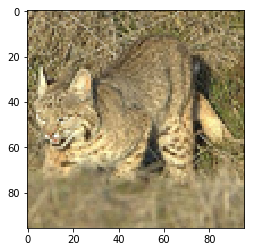

This is cat


In [269]:
img = image_sample.astype('int')
plt.imshow(img, cmap="gray")
plt.show()
label_name = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
index_of_real = label_sample.argmax()
print('This is', label_name[index_of_real])

In [270]:
training = graph.get_tensor_by_name("Placeholder:0")

In [271]:
f, p, corr= sess.run([xs, pred, correct], feed_dict={X:image_sample_feed, Y:label_sample_feed, training:False})
index_of_prediction = p[0]
print('Prediction:',label_name[index_of_prediction])
print('Correct:', corr[0])
G_real, G_pred = sess.run([grads[index_of_real], grads[index_of_prediction+1]], feed_dict={X:image_sample_feed, training:False})
G = G_pred[0]

Prediction: cat
Correct: True


In [272]:
alpha = G.mean(axis=(0,1,2))

In [273]:
f.shape, alpha.shape

((1, 16, 16, 128), (128,))

In [274]:
L = f * alpha

In [275]:
print(L.shape)
print(L.max(), L.min())
d = L.max() - L.min()

(1, 16, 16, 128)
0.025631703 -0.01227585


In [276]:
L_grad_cam = L.sum(axis=(0,3))
print(L_grad_cam.shape)

(16, 16)


In [277]:
import numpy as np
L_grad_cam = np.maximum(L_grad_cam, 0)

In [278]:
L_grad_cam = L_grad_cam / d * 255

In [279]:
L_grad_cam = L_grad_cam.astype('int')

In [280]:
L_grad_cam.shape

(16, 16)

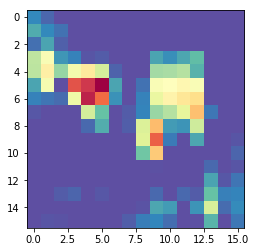

In [281]:
plt.imshow(-L_grad_cam, cmap="Spectral")

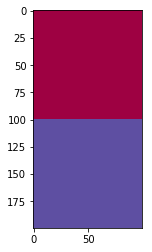

In [149]:
plt.imshow(np.vstack([np.zeros((100,100), dtype='int'),np.zeros((100,100), dtype='int')+255]), cmap='Spectral')